In [1]:
import xarray as xr
import numpy as np
from tqdm import tqdm
import time

import pytorch_lightning as pl

from project.dataset import GeoDataQueue


/Net/Groups/BGI/scratch/bkraft/mamba/envs/dml/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt

In [3]:
geodata = GeoDataQueue(fold_id=0, target_daily=['fvc'], num_queue_workers=1, chunk_buffer_size=1, batch_size=2)

In [9]:
batch = next(iter(geodata.train_dataloader()))

In [10]:
batch.f_hourly.shape

torch.Size([2, 7300, 24, 4])

In [11]:
batch.coords

Coords(lat=tensor([52.5000, 52.5000], dtype=torch.float64), lon=tensor([25.5000, 25.6000], dtype=torch.float64), chunk=tensor([0, 0]), window_start=['2004-01-01', '2004-01-01'], window_end=['2021-12-31', '2021-12-31'], num_days=tensor([6574, 6574]))

In [93]:

from torch import nn
from torch import Tensor

from project.pl_models.base_model import LightningNet
from modules.lstm import LSTM
from modules.feedforward import FeedForward
from utils.torch_utils import Transform


class LSTMPL(LightningNet):
    def __init__(
            self,
            num_inputs: int,
            num_geofactors: int,
            num_outputs: int,
            num_hidden: int,
            num_layers: int,
            dropout: float,
            static_dropout: float,
            num_geofactors_enc: int = 6,
            predict_var: bool = False,
            **kwargs) -> None:
        """Implements a long short-term memory model (LSTM).

        Note:
            The LSTM layers are followed by a feedfoward layer to map the output channels to `num_outputs`.

        Shapes:
            Input:  (batch_size, input_size, sequence_length)
            Output: (batch_size, sequence_length, num_outputs)

        Args:
            num_inputs:
                The number input dimensionality.
            num_geofactors:
                The number of static features.
            num_outputs:
                The output dimensionality.
            num_hidden:
                The number of hidden units.
            num_layers:
                The number of hidden fully-connected layers.
            dropout:
                The dropout applied after each layer, in range [0, 1).
            static_dropout:
                The dropout applied after each layer of static input mapping, in range [0, 1).
            activation:
                The activation function, defaults to 'relu'.
            num_geofactors_enc:
                The geofactor encoding dimensionality.
            predict_var:
                Whether to predict uncertainty, default is False.
            **kwargs:
                Are passed to the parent class `LightningNet`.

        """

        super().__init__(**kwargs)

        self.predict_var = predict_var

        self.encode_static = FeedForward(
            num_inputs=num_geofactors,
            num_outputs=num_geofactors_enc,
            num_hidden=32,
            num_layers=2,
            dropout=static_dropout,
            activation='relu',
            activation_last='tanh',
            dropout_last=False
        )

        self.flatten_time = Transform(
            transform_fun=lambda x: x.transpose(2, 1).reshape(x.shape[0], -1, x.shape[-1])
        )

        self.lstm = LSTM(
            num_inputs=num_inputs,
            num_static_inputs=num_geofactors_enc,
            num_outputs=-1,
            num_hidden=num_hidden,
            num_layers=num_layers,
            dropout=dropout
        )

        self.to_sequence_last = Transform(
            transform_fun=lambda x: x.permute(0, 2, 1)
        )

        self.mean_downscale = nn.Conv1d(
            in_channels=num_hidden,
            out_channels=num_outputs,
            kernel_size=24,
            stride=24
        )

        if self.predict_var:
            self.var_downscale = nn.Conv1d(
                in_channels=num_hidden,
                out_channels=num_outputs,
                kernel_size=24,
                stride=24
            )
            self.var_act = nn.Softplus()

        self.to_channel_last = Transform(
            transform_fun=lambda x: x.permute(0, 2, 1)
        )

        self.save_hyperparameters()

    def forward(self, x: Tensor, s: Tensor | None = None) -> tuple[Tensor, Tensor]:
        """Model forward call.

        Args:
            x: the sequencial tensor with shape (batch_size, sequence_length, features).
            s: the static features with shape (batch_size, features)

        Returns:
            the mean and variance estimates, both with shape (batch_size, sequence_length, num_outputs).
        """

        if s is not None:
            #  (B, FS) -> (B, FS*)
            s = self.encode_static(s)

        print(f'{x.shape=}')

        # (B, H, S, FH) -> (B, HxS, FH)
        out = self.flatten_time(x)
        out_f = out

        print(f'{out.shape=}')

        # (B, HxS, FH), (B, FS*) -> (B, HxS, D)
        out, _ = self.lstm(out, s)

        print(f'{out.shape=}')

        # (B, HxS, D) -> (B, D, HxS)
        out = self.to_sequence_last(out)

        print(f'{out.shape=}')

        # (B, D, HxS) -> (B, S, O)
        out_mean = self.to_channel_last(self.mean_downscale(out))

        print(f'{out_mean.shape=}')

        if self.predict_var:
            # (B, D, HxS) -> (B, S, O)
            out_var = self.to_channel_last(self.var_act(self.var_downscale(out)))
        else:
            out_var = None

        return out_mean, out_var, out_f


In [94]:
model = LSTMPL(num_inputs=4, num_geofactors=6, num_outputs=1, num_hidden=16, num_layers=1, dropout=0.1, static_dropout=0.1)

/Net/Groups/BGI/scratch/bkraft/mamba/envs/dml/lib/python3.10/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [95]:
m, v, f = model(batch.f_hourly, batch.f_static)
m = m.detach().cpu()
f = f.detach().cpu()

x.shape=torch.Size([50, 24, 7305, 4])
out.shape=torch.Size([50, 175320, 4])
out.shape=torch.Size([50, 175320, 16])
out.shape=torch.Size([50, 16, 175320])
out_mean.shape=torch.Size([50, 7305, 1])


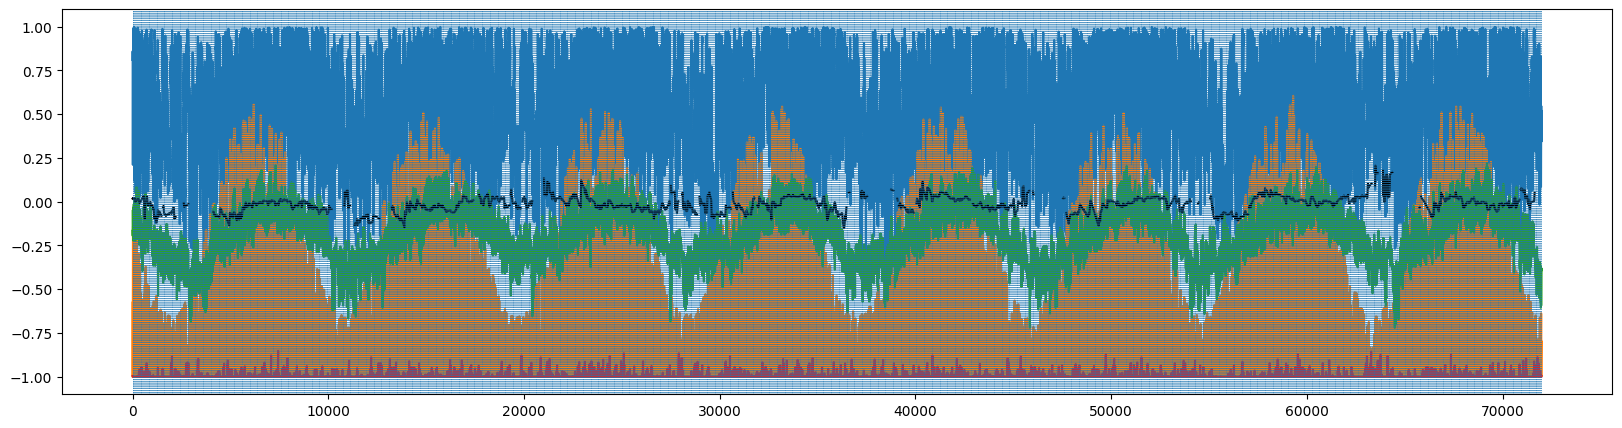

In [90]:

plt.figure(figsize=(20, 5))

n = 3000

for i in range(4):
    plt.plot(f[0, 1000 * 24:(1000 + n) * 24, i])

plt.plot(range(0, 24 * n, 24), batch.t_daily[0, 1000:1000+n, 0], color='k')

for i in range(0, 24 * n, 24):
    plt.axvline(i, ls=':', lw=0.5)

In [60]:
import os
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter


def plot_preds(writer, step, batch, preds):
    if batch.t_daily is None:
        num_daily = 0
    else:
        num_daily = batch.t_daily.shape[-1]

    if batch.f_hourly is None:
        num_hourly = 0
    else:
        num_hourly = batch.f_hourly.shape[-1]

    num_vars = num_daily + num_hourly

    fig, axes = plt.subplots(num_vars, 1, figsize=(8, num_vars), sharex=True)

    for t in range(num_daily):
        ax = axes[t]
        obs = batch.t_daily[0, :, t].cpu()
        # pred = preds.mean_hat[0, :, t].cpu()
        pred = obs + 0.1
        t_range = range(len(obs))

        #if preds.var_hat is not None:
        ax.fill_between(t_range, pred - np.sin(t_range) / 2, pred + np.sin(t_range) / 2, alpha=0.2, color='k', label='var')
        ax.plot(t_range, pred, color='k', lw=0.8, label='pred')

        ax.plot(t_range, obs, color='tab:red', lw=0.5, label='obs', alpha=0.8)
        

    for t in range(num_hourly):
        ax = axes[t + num_daily]
        ax.plot(batch.f_hourly[0, ..., t].mean(0), color='k', lw=0.5)
        ax.plot(batch.f_hourly[0, ..., t].mean(0) + 0.1, color='tab:red', alpha=0.8, lw=0.8)

    for ax in axes:
        ax.spines[['right', 'top', 'bottom']].set_visible(False)
        ax.axes.get_xaxis().set_visible(False)

    axes[0].legend(loc=2, frameon=False)

    plt.tight_layout()

    return fig


writer = SummaryWriter('./writer')
fig = plot_preds(writer, 0, batch, 1)
writer.add_figure('ts_plots', fig, 3, close=True)
writer.close()


In [13]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torchvision
from tensorboardX import SummaryWriter

writer = SummaryWriter('./writer')


def plot_to_tensorboard(writer, fig, step):
    """
    Takes a matplotlib figure handle and converts it using
    canvas and string-casts to a numpy array that can be
    visualized in TensorBoard using the add_image function

    Parameters:
        writer (tensorboard.SummaryWriter): TensorBoard SummaryWriter instance.
        fig (matplotlib.pyplot.fig): Matplotlib figure handle.
        step (int): counter usually specifying steps/epochs/time.
    """

    # Draw figure on canvas
    fig.canvas.draw()

    # Convert the figure to numpy array, read the pixel values and reshape the array
    img = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    # Normalize into 0-1 range for TensorBoard(X). Swap axes for newer versions where API expects colors in first dim
    img = img / 255.0
    # img = np.swapaxes(img, 0, 2) # if your TensorFlow + TensorBoard version are >= 1.8

    # Add figure in numpy "image" to TensorBoard writer
    writer.add_image('confusion_matrix', img, step)
    plt.close(fig)


def vis_confusion(writer, step, matrix, class_dict):
    """
    Visualization of confusion matrix

    Parameters:
        writer (tensorboard.SummaryWriter): TensorBoard SummaryWriter instance.
        step (int): Counter usually specifying steps/epochs/time.
        matrix (numpy.array): Square-shaped array of size class x class.
            Should specify cross-class accuracies/confusion in percent
            values (range 0-1).
        class_dict (dict): Dictionary specifying class names as keys and
            corresponding integer labels/targets as values.
    """

    all_categories = sorted(class_dict, key=class_dict.get)

    # Normalize by dividing every row by its sum
    matrix = matrix.astype(float)
    for i in range(len(class_dict)):
        matrix[i] = matrix[i] / matrix[i].sum()

    # Create the figure
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Show the matrix and define a discretized color bar
    cax = ax.matshow(matrix)
    fig.colorbar(cax, boundaries=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

    # Set up axes. Rotate the x ticks by 90 degrees.
    ax.set_xticklabels([''] + all_categories, rotation=90)
    ax.set_yticklabels([''] + all_categories)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Turn off the grid for this plot. Enforce a tight layout to reduce white margins
    ax.grid(False)
    plt.tight_layout()

    # Call our auxiliary to TensorBoard function to render the figure 
    plot_to_tensorboard(writer, fig, step)

vis_confusion()

In [3]:
from project.pl_models.tcn_model import TemporalConvNetPL
from project.utils.torch_utils import count_parameters

In [4]:
tcn = TemporalConvNetPL(
    num_inputs=geodata.num_features_hourly, num_geofactors=geodata.num_features_static, num_outputs=1, num_hidden=32, num_layers=3, dropout=0.2, static_dropout=0.2, kernel_size=3,
    tasks='fvc', lr=0.001, weight_decay=0.001)

In [5]:
trainer = pl.Trainer(accelerator='gpu', devices=[7])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
trainer.fit(tcn, datamodule=geodata)

/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/pytorch_lightning/core/optimizer.py:182: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  rank_zero_warn(

  | Name             | Type            | Params
-----------------------------------------------------
0 | loss_fn          | RegressionLoss  | 0     
1 | encode_static    | FeedForward     | 2.5 K 
2 | flatten_time     | Transform       | 0     
3 | to_sequence_last | Transform       | 0     
4 | tcn              | TemporalConvNet | 18.8 K
5 | tcn_mean         | TemporalConvNet | 7.5 K 
6 | tcn_var          | TemporalConvNet | 7.5 K

Sanity Checking: 0it [00:00, ?it/s]

/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:178: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  rank_zero_warn(
/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:132: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  rank_zero_warn(


tensor([[[3.4539e+16],
         [3.4539e+16],
         [3.4539e+16],
         ...,
         [       nan],
         [       nan],
         [       nan]],

        [[3.4539e+16],
         [3.4539e+16],
         [3.4539e+16],
         ...,
         [       nan],
         [       nan],
         [       nan]],

        [[3.4539e+16],
         [3.4539e+16],
         [3.4539e+16],
         ...,
         [       nan],
         [       nan],
         [       nan]],

        ...,

        [[3.4539e+16],
         [3.4539e+16],
         [3.4539e+16],
         ...,
         [       nan],
         [       nan],
         [       nan]],

        [[3.4539e+16],
         [3.4539e+16],
         [3.4539e+16],
         ...,
         [       nan],
         [       nan],
         [       nan]],

        [[3.4539e+16],
         [3.4539e+16],
         [3.4539e+16],
         ...,
         [       nan],
         [       nan],
         [       nan]]], device='cuda:7')
tensor([[[3.4539e+16],
         [3.4539e+16],

/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:132: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [15]:
tcn(batch.f_hourly, batch.f_static)

tensor([[[0.0125],
         [0.0167],
         [0.0180],
         ...,
         [0.0172],
         [0.0154],
         [0.0175]],

        [[0.0130],
         [0.0169],
         [0.0162],
         ...,
         [0.0173],
         [0.0167],
         [0.0143]],

        [[0.0127],
         [0.0160],
         [0.0170],
         ...,
         [0.0163],
         [0.0171],
         [0.0157]],

        ...,

        [[0.0123],
         [0.0167],
         [0.0166],
         ...,
         [0.0155],
         [0.0182],
         [0.0174]],

        [[0.0140],
         [0.0176],
         [0.0186],
         ...,
         [0.0180],
         [0.0176],
         [0.0169]],

        [[0.0123],
         [0.0161],
         [0.0179],
         ...,
         [0.0177],
         [0.0173],
         [0.0165]]], grad_fn=<PermuteBackward0>)

In [6]:
train_loader = geodata.train_dataloader()

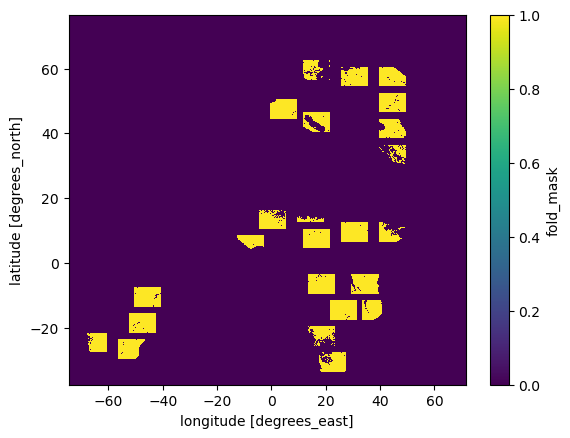

In [7]:
train_loader.dataset.mask.plot()

In [8]:
target = xr.full_like(train_loader.dataset.mask, np.nan, dtype='float32')

import traceback
try:
    for i, b in tqdm(enumerate(train_loader), maxinterval=0.1, total=len(train_loader), ncols=80):
        target.loc[{'lat': xr.DataArray(b.coords.lat), 'lon': xr.DataArray(b.coords.lon)}] = i
        time.sleep(0.5)
except:
    traceback.print_exc()

  0%|                                       | 2/2213 [00:57<17:45:35, 28.92s/it]
Traceback (most recent call last):
  File "/raid/scratch/tmp/ipykernel_46646/161158528.py", line 5, in <module>
    for i, b in tqdm(enumerate(train_loader), maxinterval=0.1, total=len(train_loader), ncols=80):
  File "/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/tqdm/std.py", line 1195, in __iter__
    for obj in iterable:
  File "/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 628, in __next__
    data = self._next_data()
  File "/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1316, in _next_data
    idx, data = self._get_data()
  File "/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1282, in _get_data
    success, data = self._try_get_data()
  File "/Net/Groups/BGI/peopl

In [11]:
batch.f_hourly.shape

torch.Size([50, 24, 1000, 4])

In [12]:
b.f_hourly.shape

torch.Size([50, 24, 7305, 4])

In [13]:
batch.f_static.shape

torch.Size([50, 6])

In [14]:
b.f_static.shape

torch.Size([50, 6])

RuntimeError: Given groups=1, weight of size [32, 4, 3], expected input[50, 24000, 4] to have 4 channels, but got 24000 channels instead

In [19]:
import matplotlib.pyplot as plt

In [44]:
b.f_hourly = b.f_hourly.view(b.f_hourly.shape[0], -1, b.f_hourly.shape[-1])

AttributeError: can't set attribute

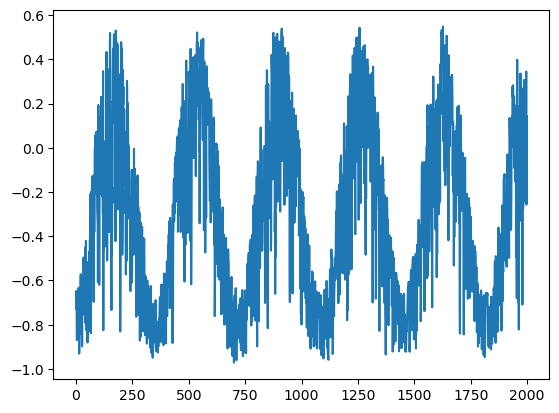

In [43]:
plt.plot(br[49, :2000, 1])

In [14]:
b.f_hourly.shape

torch.Size([50, 24, 7305, 4])

In [5]:
count_parameters(tcn)

+------------------------------------------+------------+
|                 Modules                  | Parameters |
+------------------------------------------+------------+
| feedforward_static.model.linear00.weight |    192     |
|  feedforward_static.model.linear00.bias  |     32     |
| feedforward_static.model.linear01.weight |    256     |
|  feedforward_static.model.linear01.bias  |     8      |
|           tcn.tcn.0.conv1.bias           |     32     |
|         tcn.tcn.0.conv1.weight_g         |     32     |
|         tcn.tcn.0.conv1.weight_v         |    384     |
|           tcn.tcn.0.conv2.bias           |     32     |
|         tcn.tcn.0.conv2.weight_g         |     32     |
|         tcn.tcn.0.conv2.weight_v         |    3072    |
|     tcn.tcn.0.res.downsample.weight      |    152     |
|      tcn.tcn.0.res.downsample.bias       |     38     |
|           tcn.tcn.1.conv1.bias           |     32     |
|         tcn.tcn.1.conv1.weight_g         |     32     |
|         tcn.

19347

In [3]:
tcn

TemporalConvNetPL(
  (feedforward_static): FeedForward(
    (model): Sequential(
      (linear00): Linear(in_features=6, out_features=32, bias=True)
      (dropout00): Dropout(p=0.2, inplace=False)
      (activation00): ReLU()
      (linear01): Linear(in_features=32, out_features=8, bias=True)
      (dropout01): Dropout(p=0.2, inplace=False)
      (activation01): Tanh()
    )
  )
  (tcn): TemporalConvNet(
    (to_sequence_last): Transform()
    (tcn): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(4, 32, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.2, inplace=False)
        (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.2, inplace=False)
        (res): Residual(
          (downsample): Conv1d(4, 38, kernel_size=(1,), stride=(1,))
        )
        (relu): ReLU()
      )
      (1): Tem

In [ ]:
import time

class Dataset(object):
    def __init__(self, max_items = 5):
        self.max_items = max_items
        self.chunks = []

    def add_item(self, x):
        self.chunks.appendd(x)

    def get_item(self, n):
        if len(self.chunks) >= 0
            result = [self.chunks.pop() for _ in range(n)]
        else:
            raise StopIteration

        time.sleep(0.1)

        return 


In [61]:
import threading
import queue

class BackgroundGenerator(threading.Thread):
    def __init__(self, generator):
        threading.Thread.__init__(self)
        self.queue = queue.Queue(1)
        self.generator = generator
        self.daemon = True
        self.start()

    def run(self):
        for item in self.generator:
            self.queue.put(item)
        self.queue.put(None)

    def next(self):
            next_item = self.queue.get()
            if next_item is None:
                 raise StopIteration
            return next_item

In [62]:
def generate(n):
    for i in range(n):
        yield i

In [64]:
bgen = BackgroundGenerator(generator=generate(10))

In [ ]:
bgen.next()

0

In [69]:
bgen.run()

KeyboardInterrupt: 

Consumer: Running
Producer: Running
>put value 0 (1 total)
>put value 1 (2 total)
>get value 0 (1 total)
>put value 2 (2 total)>got 0

>put value 3 (3 total)
>put value 4 (4 total)
>put value 5 (5 total)
>get value 1 (4 total)
>got 1
>put value 6 (5 total)
>get value 2 (4 total)
>got 2
>put value 7 (5 total)
>get value 3 (4 total)
>got 3>put value 8 (5 total)

>get value 4 (4 total)
>got 4>put value 9 (5 total)

Producer: Done
>get value 5 (4 total)
>got 5
>get value 6 (3 total)
>got 6
>get value 7 (2 total)
>got 7
>get value 8 (1 total)
>got 8
>get value 9 (0 total)
>got 9


KeyboardInterrupt: 

In [76]:
# SuperFastPython.com
# example of using the simple queue among processes
from time import sleep
from random import random
from multiprocessing import Process
from multiprocessing import SimpleQueue
 
# generate work
def producer(queue):
    print('Producer: Running', flush=True)
    # generate work
    for i in range(10):
        # generate a value
        value = random()
        # block
        #sleep(value)
        # add to the queue
        print('Put value')
        queue.put(value)
    # all done
    queue.put(None)
    print('Producer: Done', flush=True)
 
# consume work
def consumer(queue):
    print('Consumer: Running', flush=True)
    # consume work
    while True:
        # get a unit of work
        item = queue.get()
        # check for stop
        if item is None:
            break
        # report
        print(f'>got {item}', flush=True)
        sleep(1)
    # all done
    print('Consumer: Done', flush=True)
 
# create the shared queue
queue = SimpleQueue()
# start the consumer
consumer_process = Process(target=consumer, args=(queue,))
consumer_process.start()
# start the producer
producer_process = Process(target=producer, args=(queue,))
producer_process.start()
# wait for all child processes to finish
producer_process.join()
consumer_process.join()

Consumer: Running
Producer: Running
Put value
>got 0.5167574710624812Put value

Put value
Put value
Put value
Put value
Put value
Put value
Put value
Put value
Producer: Done
>got 0.8092434984658852
>got 0.31689718979925574
>got 0.820357973428891
>got 0.3068956683358398
>got 0.3917735942309919
>got 0.7456238883130152
>got 0.6774774386586543
>got 0.5731500276208481
>got 0.27763739356529193
Consumer: Done


In [73]:
queue

AttributeError: 'SimpleQueue' object has no attribute 'qsize'

In [60]:

import torch
from torch.utils.data import IterableDataset, DataLoader
import time
import numpy as np


In [61]:
# SuperFastPython.com
# example of using the simple queue among processes
import torch.multiprocessing as mpl
from torch.multiprocessing import Process, SimpleQueue
from time import sleep
from random import random

#n_enqueued = mpl.Value('i', 0)

# generate work
def producer(queue, n_enqueued):
    print('Producer: Running', flush=True)
    # generate work
    current_value = 0
    exit = False
    while True:
        if exit:
            break

        if n_enqueued.value < 5:
            # add to the queue
            queue.put(current_value)
            with n_enqueued.get_lock():
                n_enqueued.value += 1
                print(f'>put value {current_value} ({n_enqueued.value} total)')

            current_value += 1

            if current_value >= 10:
                exit = True

        else:
            sleep(0.5)

    # all done
    queue.put(None)
    print('Producer: Done', flush=True)


In [64]:
class Buffer(object):
    def __init__(self):
        self.queue = SimpleQueue()
        self.n_enqueued = mpl.Value('i', 0)

        self.producer_process = Process(target=producer, args=(self.queue, self.n_enqueued,))
        self.producer_process.start()

    def next(self):
        while True:
            if self.n_enqueued.value < 1:
                sleep(1)
                continue

            with self.n_enqueued.get_lock():
                self.n_enqueued.value -= 1

            value = self.queue.get()
            print(f'>get value {value} ({self.n_enqueued.value} total)')
            return value

    def terminate(self):
        self.producer_process.join()


class Data(IterableDataset):
    def __init__(self):
        super().__init__()

    def __iter__(self):
        queue = SimpleQueue()
        buffer = Buffer()

        while True:
            el = buffer.next()

            if el is None:
                buffer.terminate()
                break

            print(el)

            yield el


data = Data()
dataloader = DataLoader(data, prefetch_factor=2, num_workers=1)


In [65]:
if __name__ == '__main__':
    for d in dataloader:
        sleep(0.5)
        print(d)

AssertionError: Caught AssertionError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 34, in fetch
    data.append(next(self.dataset_iter))
  File "/raid/scratch/tmp/ipykernel_23727/3276945696.py", line 32, in __iter__
    buffer = Buffer()
  File "/raid/scratch/tmp/ipykernel_23727/3276945696.py", line 7, in __init__
    self.producer_process.start()
  File "/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/multiprocessing/process.py", line 118, in start
    assert not _current_process._config.get('daemon'), \
AssertionError: daemonic processes are not allowed to have children


In [28]:
import torch.multiprocessing as mp

In [36]:
class A(object):
    def __init__(self):
        self.n = 0

    def increase(self):
        self.n += 1

In [37]:
processes = []
aaa = []
for _ in range(2):
    a = A()

    aaa.append(a)
    process = mp.Process(target=a.increase)
    process.start()
    processes.append(process)

for process in processes:
    process.join()


In [39]:
aaa[1].n

0

In [41]:
import xarray as xr
import numpy as np

In [53]:
mask = xr.DataArray(np.random.choice(2, size=(10, 10)), dims=['lat', 'lon'], coords={'lat': np.arange(10), 'lon': np.arange(10)})

In [67]:
np.argwhere(mask.stack(sample=('lat', 'lon')).values).squeeze()

array([ 0,  2,  3,  5,  7, 10, 12, 15, 16, 17, 18, 20, 21, 22, 26, 27, 28,
       30, 32, 33, 37, 42, 44, 46, 47, 48, 49, 50, 52, 54, 55, 56, 57, 58,
       62, 64, 65, 66, 67, 69, 73, 76, 77, 79, 80, 84, 86, 87, 89, 91, 93,
       95, 98, 99])

In [54]:
mask_flat = mask.stack(sample=('lat', 'lon')).reset_coords()
mask_flat

ValueError: cannot reset_coords with drop=False on an unnamed DataArrray

In [92]:
m = mask_flat.where(mask_flat, drop=True)

In [93]:
m

<xarray.DataArray (sample: 52)>
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])
Coordinates:
  * sample   (sample) object MultiIndex
  * lat      (sample) int64 0 0 0 0 1 1 1 1 1 1 2 2 ... 7 7 7 8 8 8 8 8 8 8 8 9
  * lon      (sample) int64 0 1 4 7 0 1 2 4 5 6 0 3 ... 6 8 9 1 2 4 5 6 7 8 9 4

In [68]:
np.random.shuffle([1])

In [3]:
import torch.multiprocessing as mp
import queue

In [8]:
q = mp.Manager().Queue()

In [9]:
try:
    q.get(block=False)
    print('try')
except queue.Empty:
    print('empty')

empty


: 

In [1]:
import xarray as xr

In [2]:
order = xr.open_dataset('../order.nc')
count = xr.open_dataset('../count.nc')

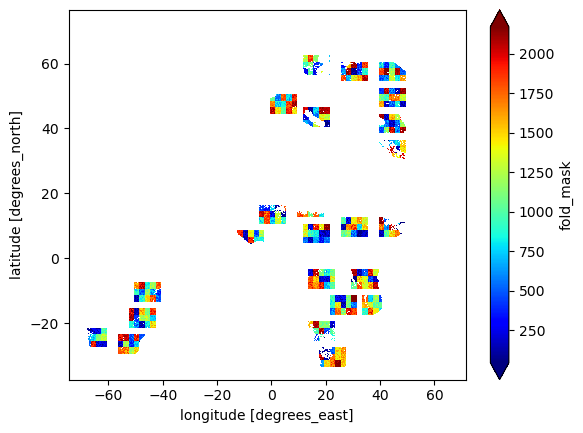

In [4]:
order.fold_mask.plot(robust=True, cmap='jet')

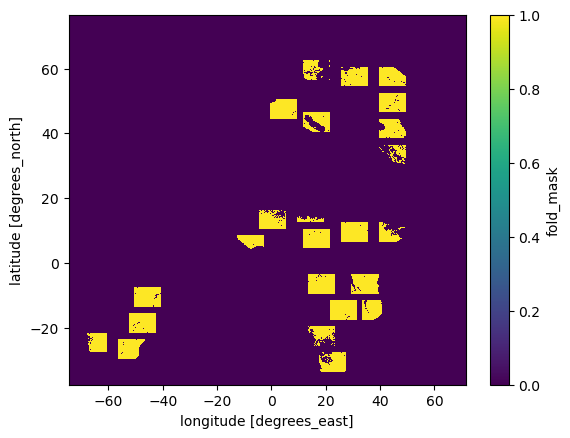

In [3]:
count.fold_mask.plot()

In [4]:
mask = xr.open_zarr('/Net/Groups/BGI/scratch/bkraft/drought_data/cube.zarr').fold_mask

In [5]:
mask = mask.chunk({'lat': -1, 'lon': -1})

In [7]:
mask = mask.load()

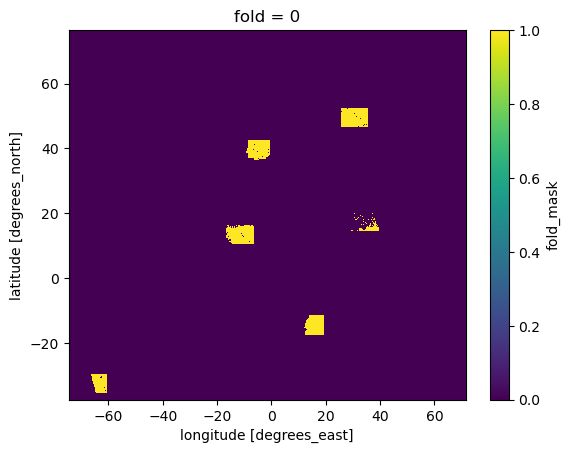

In [14]:
mask.isel(fold=0).plot()

In [33]:
import xarray as xr
import numpy as np
ds = xr.open_zarr('/Net/Groups/BGI/scratch/bkraft/drought_data/cube.zarr')

mask = ds.mask.load()
chunk_mask = (mask.coarsen(lat=20, lon=20).sum()) > 200
lat_min, lon_min = np.argwhere(chunk_mask.values)[0] * 20
lat_max, lon_max = (np.argwhere(chunk_mask.values)[0] + 1) * 20
mask  = mask.isel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max)).load()
data  = ds[['fvc']].isel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max), time=slice(1000, 1100)).load()

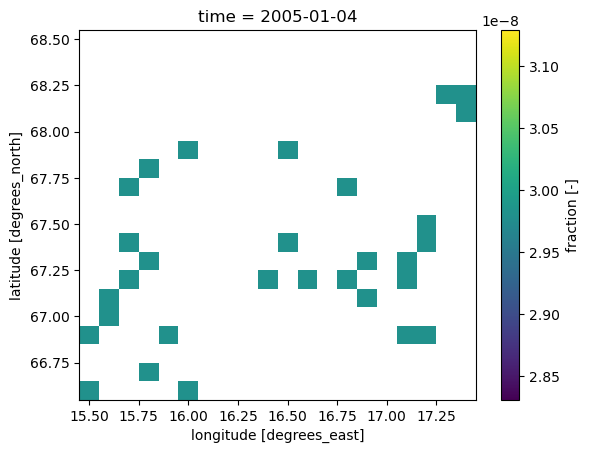

In [34]:
data.fvc.isel(time=-1).plot()

In [48]:
class DataChunk(object):
    """Defines a single chunk and how to retreive data from it."""
    def __init__(
            self,
            data: xr.Dataset,
            mask: xr.DataArray,
            shuffle: bool = False) -> None:

        data = data.load()
        mask = mask.load()

        mask = mask.stack(sample=('lat', 'lon')).reset_coords(drop=True).load()
        data = data.stack(sample=('lat', 'lon')).reset_coords(drop=True)
        self.data = data.where(mask, drop=True).load()

        self.shuffle = shuffle

        self.coords = self._get_coords()

        self._current_sample = 0

    def _get_coords(self):
        coords = np.arange(len(self.data.sample))
        if self.shuffle:
            np.random.shuffle(coords)
        return coords


In [49]:
dc = DataChunk(data=data, mask=mask)

In [50]:
dc.data.isel(sample=0).lat.item()

68.5

In [51]:
dc.data

<xarray.Dataset>
Dimensions:  (time: 100, sample: 273)
Coordinates:
  * time     (time) datetime64[ns] 2004-09-27 2004-09-28 ... 2005-01-04
  * sample   (sample) object MultiIndex
  * lat      (sample) float32 68.5 68.5 68.5 68.5 68.5 ... 66.6 66.6 66.6 66.6
  * lon      (sample) float32 15.6 15.7 15.8 16.1 16.2 ... 17.1 17.2 17.3 17.4
Data variables:
    fvc      (time, sample) float32 2.98e-08 nan nan nan nan ... nan nan nan nan

In [37]:
dc.data

<xarray.Dataset>
Dimensions:  (time: 100, sample: 273)
Coordinates:
  * time     (time) datetime64[ns] 2004-09-27 2004-09-28 ... 2005-01-04
  * sample   (sample) object MultiIndex
  * lat      (sample) float32 68.5 68.5 68.5 68.5 68.5 ... 66.6 66.6 66.6 66.6
  * lon      (sample) float32 15.6 15.7 15.8 16.1 16.2 ... 17.1 17.2 17.3 17.4
Data variables:
    fvc      (time, sample) float32 2.98e-08 nan nan nan nan ... nan nan nan nan

In [38]:
dc.mask

<xarray.DataArray 'mask' (sample: 400)>
array([False,  True,  True,  True, False, False,  True,  True,  True,
       False, False, False,  True,  True,  True,  True, False, False,
       False, False,  True,  True,  True, False,  True,  True, False,
       False,  True, False, False, False,  True, False,  True, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False,  True, False,
        True,  True,  True, False, False,  True, False,  True, False,
       False, False,  True,  True, False,  True, False,  True, False,
        True,  True,  True, False, False, False,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True, False, False,  True,
        True,  True,  True,  True,  True, False,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
...
        True, False, False,  True,  True,  True,  True, False, False,
        True, False,  True,  True, False, False,  True,  True,  True,
        True,  True, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
       False,  True,  True,  True,  True, False, False, False, False,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])
Coordinates:
  * sample   (sample) object MultiIndex
  * lat      (sample) float32 68.5 68.5 68.5 68.5 68.5 ... 66.6 66.6 66.6 66.6
  * lon      (sample) float32 15.5 15.6 15.7 15.8 15.9 ... 17.1 17.2 17.3 17.4

In [1]:
def iterate():
    i = 0
    try:
        while True:
            result = i
            i += 1
            if i == 5:
                return
            yield result
    finally:
        print('finally')

In [3]:
for j in range(2):
    for i in iterate():
        print(i)

0
1
2
3
finally
0
1
2
3
finally


In [6]:
import xarray as xr

mask = xr.open_zarr('/Net/Groups/BGI/scratch/bkraft/drought_data/cube.zarr').fold_mask

In [8]:
ind_x = xr.DataArray([76.5,  76.4], dims=["x"])
ind_y = xr.DataArray([-74.5, -74.4], dims=["y"])

In [9]:
mask[ind_x, ind_y]

TypeError: invalid indexer array, does not have integer dtype: array([76.5, 76.4])

In [1]:
from dataset import GeoDataQueue
from collections import namedtuple

ReturnPattern = namedtuple('ReturnPattern', 'mean_hat var_hat coords')


geodata = GeoDataQueue(
    fold_id=0,
    target_daily=['fvc'],
    batch_size=4,
    chunk_buffer_size=1,
    num_queue_workers=12,
)

geodata.setup('predict')
pdl = geodata.predict_dataloader()

class Trainer(object):
    def __init__(self, dataloader):
        self.predict_dataloaders = [dataloader]
        self.log_dir = './'

trainer = Trainer(pdl)


/Net/Groups/BGI/scratch/bkraft/mamba/envs/dml/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import BasePredictionWriter
import xarray as xr
import os
from torch import Tensor
import shutil
import logging
import numpy as np
import torch.multiprocessing as mp
from time import sleep
from collections import namedtuple

from typing import Any, Sequence, NamedTuple

from dataset import QueueFiller
from utils.types import ReturnPattern, Coords



logger = logging.getLogger('user_logger')

class OutputWriter(BasePredictionWriter):
    """Output writer to use as callback in prediction mode."""
    def __init__(
            self,
            overwrite: bool | str = True) -> None:
        """Initialize OutputWriter.

        Results are written to the trainer logging directory as `predictions.zarr`. Predictions
        are expected in `ReturnPattern` format. Note that `ReturnPattern.var_hat` (the optional
        uncertainties) may be `None`. In this case, no variable is created for uncertainties and
        only the mean is written to file. For each target, the resulting zarr file has the variables
        - '<target>_hat' (mean)
        - '<target>_vhat' (optional variance)

        Example:
        >>> pred_writer = OutputWriter()
        >>> trainer = Trainer(callbacks=[pred_writer])
        >>> model = MyModel()
        >>> trainer.predict(model, return_predictions=False)

        Args:
            overwrite: if `True` (default), existing predictions are overridden. Else, an error
                is raised if the target exists.
        """
        super().__init__(write_interval='batch')

        self.overwrite = overwrite

        # self.targets: list[str] = None
        self.targets: list[str] = ['fvc'] ####
        self.zarr_file: xr.Dataset | None = None
        self.mask: xr.DataArray | None = None
        self.chunk_coords: np.typing.ArrayLike | None = None
        self.num_year_samples: int = None

        self.processes: list[mp.Process] = []
        self.chunks = {}

    def write_on_batch_end(
            self,
            trainer: pl.Trainer,
            pl_module: pl.LightningModule,
            prediction: ReturnPattern,
            batch_indices: Sequence[int] | None,
            batch: Any,
            batch_idx: int,
            dataloader_idx: int) -> None:

        if self.zarr_file is None:
            self.has_variance = prediction.var_hat is not None
            chunk_size = \
                self.init_zarr(
                    trainer=trainer, dataloader_idx=dataloader_idx, has_variance=self.has_variance
                )
            self.chunk_bounds_lat = QueueFiller.coords2bounds(self.mask, dim='lat', chunk_size=chunk_size)
            self.chunk_bounds_lon = QueueFiller.coords2bounds(self.mask, dim='lon', chunk_size=chunk_size)
            self.targets = ['fvc'] ####

        for i in range(len(prediction.coords.chunk)):
            i_pred = self.subset_namedtuple(prediction, i)
            chunk_id = i_pred.coords.chunk

            if chunk_id not in self.chunks:
                chunk_lat, chunk_lon = self.chunk_coords[chunk_id]

                lat_bounds = slice(*self.chunk_bounds_lat[chunk_lat])
                lon_bounds = slice(*self.chunk_bounds_lon[chunk_lon])
                num_samples = self.mask.isel(lat=lat_bounds, lon=lon_bounds).sum().compute()

                chunk_ds = self.get_target_like(
                    self.zarr_file.isel(lat=lat_bounds, lon=lon_bounds),
                    has_variance=self.has_variance,
                    use_orig_name=False
                )

                self.chunks[chunk_id] = {
                    'ds': chunk_ds,
                    'num_samples': num_samples * self.num_year_samples,
                    'num_saved': 0,
                    'lat_bounds': lat_bounds,
                    'lon_bounds': lon_bounds
                }

            for target_i, target in enumerate(self.targets):
                self.chunks[chunk_id]['ds'][
                    self.get_target_pred_name(name=target, is_variance=False)
                ].loc[{
                    'lat': i_pred.coords.lat,
                    'lon': i_pred.coords.lon,
                    'time': slice(i_pred.coords.window_start, i_pred.coords.window_end)}] =\
                            i_pred.mean_hat[-i_pred.coords.num_days:, ..., target_i]

                if self.has_variance:
                    self.chunks[chunk_id]['ds'][
                        self.get_target_pred_name(name=target, is_variance=True)
                    ].loc[{
                        'lat': i_pred.coords.lat,
                        'lon': i_pred.coords.lon,
                        'time': i_pred.coords.time_slice}] =\
                            i_pred.var_hat[-i_pred.coords.num_days:, ..., target_i]

            self.chunks[chunk_id]['num_saved'] += 1

            if self.chunks[chunk_id]['num_saved'] == self.chunks[chunk_id]['num_samples']:
                process = mp.Process(target=self.write_chunk, args=(self.chunks[chunk_id],))
                self.processes.append(process)
                process.start()
                del self.chunks[chunk_id]

            remove_processes = []
            for process_i, process in enumerate(self.processes):
                if not process.is_alive():
                    remove_processes.append(process_i)

            if len(remove_processes) > 0:

                for process_i in reversed(remove_processes):
                    process = self.processes.pop(process_i)
                    process.terminate()
                    process.join()

    def on_predict_epoch_end(
            self,
            trainer: pl.Trainer,
            pl_module: pl.LightningModule,
            outputs: Sequence[Any]) -> None:

        for chunk in self.chunks.values():
            self.write_chunk(chunk)

        self.chunks = {}

    def write_chunk(self, chunk: dict) -> None:
        chunk_ds = chunk['ds'].drop_vars(['time'])

        chunk_ds.to_zarr(self.zarr_file.encoding['source'], consolidated=True, region={
            'lat': chunk['lat_bounds'],
            'lon': chunk['lon_bounds']
        })

    def init_zarr(
            self, trainer: 'pl.Trainer',
            dataloader_idx: int,
            has_variance: bool) -> tuple[int, int]:

        # zarr_dir = os.path.join(trainer.log_dir, 'predictions.zarr')
        zarr_dir = os.path.join('./', 'predictions.zarr') ####

        if os.path.isdir(zarr_dir):
            if self.overwrite:
                shutil.rmtree(zarr_dir)

            else:
                raise FileExistsError(
                    f'The zar file {zarr_dir} already exists. Set `OutputWriter(..., overwrite=True)` '
                    'to overwrite the file.'
                )

        dataset = trainer.predict_dataloaders[dataloader_idx].dataset
        data = dataset.data

        missing_targets = []
        for target in self.targets:
            if not target in data.data_vars:
                missing_targets.append(target)

        if len(missing_targets) > 0:
            raise KeyError(
                f'some target(s) missing in dataset: {missing_targets}.'
            )

        dummy = self.get_target_like(data, has_variance=has_variance, use_orig_name=True)
        dummy['fold'] = xr.ones_like(self.mask, dtype=int) * dataset.fold_id
        dummy.to_zarr(zarr_dir, compute=False)

        self.targets = dataset.targets
        self.zarr_file = xr.open_zarr(zarr_dir)
        self.mask = dataset.mask
        self.chunk_coords = dataset.chunk_coords
        self.num_year_samples = dataset.num_year_samples

        return dataset.chunk_size

    def get_target_like(self, data: xr.Dataset, has_variance: bool, use_orig_name: bool) -> xr.Dataset:
        dummy = xr.Dataset()
        for target in self.targets:
            name = target if use_orig_name else self.get_target_pred_name(name=target, is_variance=False)
            dummy[self.get_target_pred_name(name=target, is_variance=False)] = data[name]
            if has_variance:
                dummy[self.get_target_pred_name(name=target, is_variance=True)] = data[name]

        return xr.full_like(dummy, fill_value=np.nan)

    @staticmethod
    def get_target_pred_name(name: str, is_variance: bool) -> bool:
        if is_variance:
            return name + '_vhat'
        else:
            return name + '_hat'

    @staticmethod
    def isnamedtuple(obj) -> bool:
        return (
                isinstance(obj, tuple) and
                hasattr(obj, '_asdict') and
                hasattr(obj, '_fields')
        )

    def subset_namedtuple(self, x: Any, ind: int) -> namedtuple:
        el_type = type(x)

        el_list = []
        for el in x:
            if self.isnamedtuple(el):
                el_subset = self.subset_namedtuple(el, ind)
            elif el is None:
                el_subset = None
            else:
                el_subset = el[ind]
                if isinstance(el_subset, str):
                    # For dates in string format.
                    pass
                elif el_subset.ndim == 0:
                    # For numpy floats and integers.
                    el_subset = el_subset.item()
                elif isinstance(el_subset, Tensor):
                    # For Tensors.
                    el_subset = el_subset.cpu().numpy()
                else:
                    raise TypeError(
                        '`el_subset` is neither a string, a float, an integer, nor a Tensor.'
                    )

            el_list.append(el_subset)

        return el_type(*el_list)

In [6]:
output_writer = OutputWriter()

In [16]:
batch.coords

Coords(lat=tensor([-25.4000, -25.4000, -25.1000], dtype=torch.float64), lon=tensor([31.3000, 31.4000, 33.7000], dtype=torch.float64), chunk=tensor([84, 84, 86]), window_start=['2004-01-01', '2004-01-01', '2004-01-01'], window_end=['2021-12-31', '2021-12-31', '2021-12-31'], num_days=tensor([6575, 6575, 6575]))

In [7]:
from tqdm import tqdm

for i, batch in tqdm(enumerate(pdl), total=len(pdl)):
    #pred = ReturnPattern(mean_hat=batch.t_daily, var_hat=batch.t_daily.abs() * 2, coords=batch.coords)
    pred = ReturnPattern(mean_hat=batch.t_daily, var_hat=None, coords=batch.coords)
    output_writer.write_on_batch_end(trainer=trainer, pl_module=None, prediction=pred, batch_indices=None, batch=None, batch_idx=None, dataloader_idx=0)

100%|██████████| 7487/7487 [09:31<00:00, 13.11it/s]


In [10]:
output_writer.on_predict_epoch_end(trainer=trainer, pl_module=None, outputs=None)

In [11]:
import xarray as xr

In [22]:
pred = xr.open_zarr('/Net/Groups/BGI/people/bkraft/drought_ml/project/predictions.zarr')
pred

FileNotFoundError: No such file or directory: '/Net/Groups/BGI/people/bkraft/drought_ml/project/predictions.zarr'

In [53]:
pred = xr.open_zarr('/Net/Groups/BGI/scratch/bkraft/drought_data/cube.zarr/')
pred

/raid/scratch/tmp/ipykernel_25098/3542381403.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  pred = xr.open_zarr('/Net/Groups/BGI/scratch/bkraft/drought_data/cube.zarr/')


<xarray.Dataset>
Dimensions:  (time: 7305, lat: 1140, lon: 1460, dayofyear: 366)
Coordinates:
  * lat      (lat) float32 76.5 76.4 76.3 76.2 76.1 ... -37.1 -37.2 -37.3 -37.4
  * time     (time) datetime64[ns] 2002-01-01 2002-01-02 ... 2021-12-31
Dimensions without coordinates: lon, dayofyear
Data variables:
    fvc      (time, lat, lon) float32 dask.array<chunksize=(300, 20, 20), meta=np.ndarray>
    fvc_msc  (dayofyear, lat, lon) float32 dask.array<chunksize=(366, 20, 20), meta=np.ndarray>
    lst      (time, lat, lon) float32 dask.array<chunksize=(300, 20, 20), meta=np.ndarray>
    lst_ano  (time, lat, lon) float32 dask.array<chunksize=(300, 20, 20), meta=np.ndarray>
    lst_msc  (dayofyear, lat, lon) float32 dask.array<chunksize=(366, 20, 20), meta=np.ndarray>
    rh_cf    (time, lat, lon) float32 dask.array<chunksize=(300, 20, 20), meta=np.ndarray>
    ssrd     (time, lat, lon) float32 dask.array<chunksize=(300, 20, 20), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(300, 20, 20), meta=np.ndarray>
    tp       (time, lat, lon) float32 dask.array<chunksize=(300, 20, 20), meta=np.ndarray>

In [18]:
def calculate_anomaly(x: xr.DataArray) -> tuple[xr.DataArray, xr.DataArray]:
    gb = x.groupby('time.dayofyear')
    msc = gb.mean('time').compute()

    msc_0 = msc.copy().assign_coords(dayofyear=np.arange(1 - 366, 1))
    msc_1 = msc.copy().assign_coords(dayofyear=np.arange(367, 367 + 366))
    msc_stack = xr.concat((msc_0, msc, msc_1), dim='dayofyear')
    msc_smooth = msc_stack.rolling(dayofyear=17, min_periods=5, center=True).mean().sel(dayofyear=slice(1, 366))

    anomalies = gb - msc_smooth
    anomalies = anomalies.drop('dayofyear')

    return msc_smooth, anomalies

In [37]:
d = pred.lst.sel(lat=slice(5, 0), lon=slice(20, 25)).load()

In [32]:
msc, ano = calculate_anomaly(d)

In [51]:
CHUNKS = {'time': 100, 'hour': 24}
chunks = CHUNKS.copy()
chunks['dayofyear'] = 366
del chunks['time']
chunks

{'hour': 24, 'dayofyear': 366}

In [48]:
ano

<xarray.DataArray 'lst' (time: 7305, hour: 24, lat: 51, lon: 51)>
array([[[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
...
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
           4.0154247 ,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,  3.6023045 ],
         [        nan,         nan,         nan, ...,  2.3467178 ,
           2.2412567 ,  2.6967506 ],
         ...,
         [        nan,         nan,  0.7555237 , ..., -1.9014435 ,
          -1.0304203 , -1.4157639 ],
         [        nan,         nan,         nan, ...,         nan,
          -1.6394424 , -1.1869621 ],
         [        nan,         nan,         nan, ...,         nan,
          -2.838955  , -1.7306709 ]]]], dtype=float32)
Coordinates:
  * hour     (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
  * lat      (lat) float32 5.0 4.9 4.8 4.7 4.6 4.5 ... 0.5 0.4 0.3 0.2 0.1 0.0
  * lon      (lon) float32 20.0 20.1 20.2 20.3 20.4 ... 24.6 24.7 24.8 24.9 25.0
  * time     (time) datetime64[ns] 2002-01-01 2002-01-02 ... 2021-12-31

In [47]:
msc

<xarray.DataArray 'lst' (dayofyear: 366, hour: 24, lat: 51, lon: 51)>
array([[[[17.855238 , 18.061747 , 17.39685  , ..., 17.321072 ,
          17.043303 , 17.213018 ],
         [18.416403 , 18.676414 , 18.47786  , ..., 17.432663 ,
          16.881365 , 16.83519  ],
         [17.037521 , 17.605871 , 18.393854 , ..., 16.468973 ,
          16.63299  , 16.542124 ],
         ...,
         [21.057367 , 21.349087 , 21.039215 , ..., 19.914066 ,
          19.583216 , 19.62093  ],
         [20.982876 , 21.241755 , 21.218487 , ..., 19.367401 ,
          19.830484 , 19.714209 ],
         [21.188053 , 21.303259 , 21.041313 , ..., 19.697262 ,
          19.676462 , 19.854446 ]],

        [[17.505037 , 17.627518 , 16.815012 , ..., 16.801018 ,
          16.933718 , 16.936794 ],
         [18.099516 , 18.26647  , 18.036034 , ..., 17.055984 ,
          16.593334 , 16.550516 ],
         [16.782564 , 17.152805 , 17.988316 , ..., 16.134716 ,
          16.274181 , 16.231337 ],
...
         [21.67153  , 21.529615 , 21.165638 , ..., 20.212952 ,
          20.189503 , 20.189154 ],
         [21.551657 , 21.320238 , 21.373587 , ..., 19.896006 ,
          20.396698 , 20.409376 ],
         [21.402569 , 21.448034 , 21.258923 , ..., 20.26001  ,
          20.171278 , 20.264477 ]],

        [[18.498037 , 18.440094 , 17.85087  , ..., 17.622646 ,
          17.605114 , 17.715174 ],
         [18.813597 , 19.021671 , 18.836168 , ..., 17.721334 ,
          17.2547   , 17.20668  ],
         [17.61414  , 17.96574  , 18.707415 , ..., 16.908922 ,
          17.066898 , 16.895298 ],
         ...,
         [21.102652 , 21.218508 , 21.045334 , ..., 19.752197 ,
          19.91862  , 19.711538 ],
         [21.020096 , 21.094841 , 21.16734  , ..., 19.660631 ,
          20.093307 , 20.183252 ],
         [21.184063 , 21.454723 , 21.149443 , ..., 19.744852 ,
          19.836672 , 20.179543 ]]]], dtype=float32)
Coordinates:
  * hour       (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23
  * lat        (lat) float32 5.0 4.9 4.8 4.7 4.6 4.5 ... 0.5 0.4 0.3 0.2 0.1 0.0
  * lon        (lon) float32 20.0 20.1 20.2 20.3 20.4 ... 24.7 24.8 24.9 25.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Attributes:
    data_max:   320.6399841308594
    data_min:   -78.58999633789062
    long_name:  fraction
    units:      -

In [38]:
r = d.groupby('time.dayofyear').mean()

In [40]:
e = xr.Dataset()

In [41]:
e['tesrt'] = r

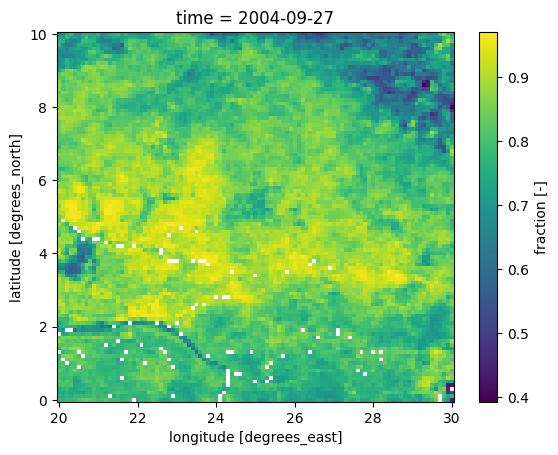

In [25]:
.plot()

In [43]:
pred

ReturnPattern(mean_hat=tensor([[[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]]]), var_hat=None, coords=Coords(lat=tensor([54.4000, 54.0000, 54.0000, 54.0000], dtype=torch.float64), lon=tensor([13.5000, 13.6000, 13.7000, 13.8000], dtype=torch.float64), chunk=tensor([1, 1, 1, 1]), window_start=['2004-01-01', '2004-01-01', '2004-01-01', '2004-01-01'], window_end=['2021-12-31', '2021-12-31', '2021-12-31', '2021-12-31'], num_days=tensor([6574, 6574, 6574, 6574])))

In [13]:
mask = xr.open_zarr('/Net/Groups/BGI/scratch/bkraft/drought_data/cube.zarr/').fold_mask.isel(fold=3).load()

In [8]:
import xarray as xr
import matplotlib.pyplot as plt

In [9]:
pred = xr.open_zarr('/Net/Groups/BGI/people/bkraft/drought_ml/lightning_logs/version_0/predictions.zarr/')
pred

FileNotFoundError: No such file or directory: '/Net/Groups/BGI/people/bkraft/drought_ml/lightning_logs/version_0/predictions.zarr'

In [3]:
obs = xr.open_zarr('/Net/Groups/BGI/scratch/bkraft/drought_data/cube.zarr/')
obs

<xarray.Dataset>
Dimensions:             (lat: 1140, lon: 1460, fold: 6, time: 7305, hour: 24)
Coordinates:
  * fold                (fold) int64 0 1 2 3 4 5
  * hour                (hour) int64 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22 23
  * lat                 (lat) float32 76.5 76.4 76.3 76.2 ... -37.2 -37.3 -37.4
  * lon                 (lon) float32 -74.5 -74.4 -74.3 -74.2 ... 71.2 71.3 71.4
  * time                (time) datetime64[ns] 2002-01-01 ... 2021-12-31
Data variables: (12/16)
    canopyheight        (lat, lon) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>
    fold_mask           (fold, lat, lon) bool dask.array<chunksize=(1, 20, 20), meta=np.ndarray>
    fvc                 (time, lat, lon) float32 dask.array<chunksize=(300, 20, 20), meta=np.ndarray>
    fvc_ano             (time, lat, lon) float32 dask.array<chunksize=(300, 20, 20), meta=np.ndarray>
    lst                 (hour, time, lat, lon) float32 dask.array<chunksize=(24, 300, 20, 20), meta=np.ndarray>
    lst_ano             (hour, time, lat, lon) float32 dask.array<chunksize=(24, 300, 20, 20), meta=np.ndarray>
    ...                  ...
    sandfrac            (lat, lon) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>
    ssrd                (hour, time, lat, lon) float32 dask.array<chunksize=(24, 300, 20, 20), meta=np.ndarray>
    t2m                 (hour, time, lat, lon) float32 dask.array<chunksize=(24, 300, 20, 20), meta=np.ndarray>
    topidx              (lat, lon) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>
    tp                  (hour, time, lat, lon) float32 dask.array<chunksize=(24, 300, 20, 20), meta=np.ndarray>
    wtd                 (lat, lon) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>

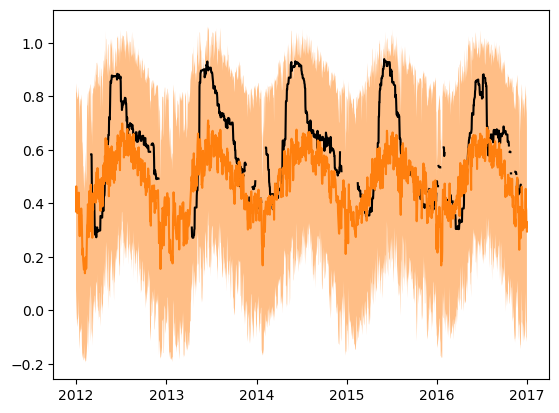

In [4]:
sel = dict(lat=51, lon=15.5, time=slice('2012', '2016'))
obs_s = obs.fvc.sel(**sel)
pred_m = pred.fvc_hat.sel(**sel)
pred_v = (pred.fvc_vhat.sel(**sel) ** 0.5) * 2
# pred_v = pred.fvc_vhat.sel(**sel)
plt.plot(obs_s.time, obs_s.values, color='k')
plt.plot(pred_m.time, pred_m.values, color='tab:orange')
plt.fill_between(pred_m.time, pred_m.values - pred_v.values, pred_m.values + pred_v.values, facecolor='tab:orange', alpha=0.5)
#obs.fvc.sel(**sel).plot()
#pred.fvc_hat.sel(**sel).plot()
#pred.fvc_vhat.sel(**sel).plot()

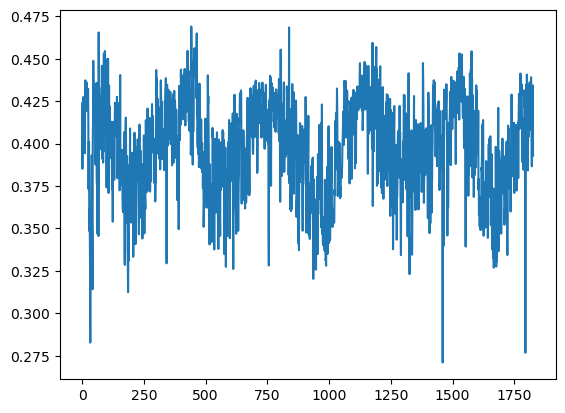

In [5]:
plt.plot(pred_v)

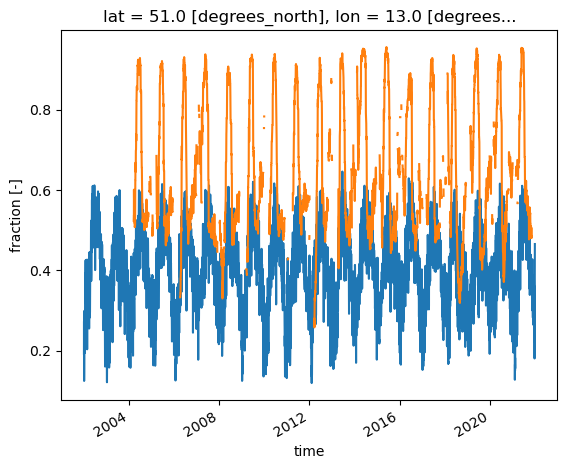

In [6]:
pred.fvc_hat.sel(lat=51, lon=13).plot()
obs.fvc.sel(lat=51, lon=13).plot()

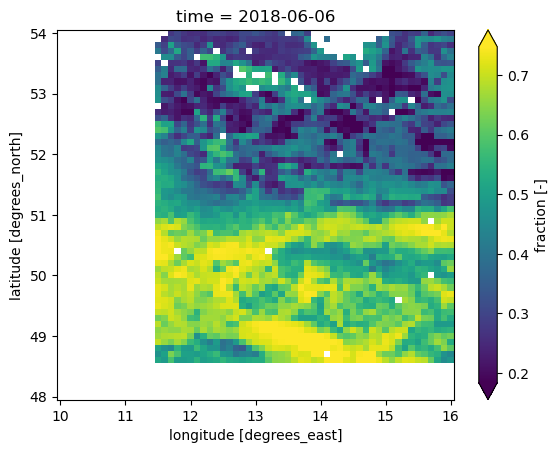

In [7]:
m = pred.fvc_hat.isel(time=6000)
m.sel(lat=slice(54, 48), lon=slice(10, 16)).plot(robust=True)

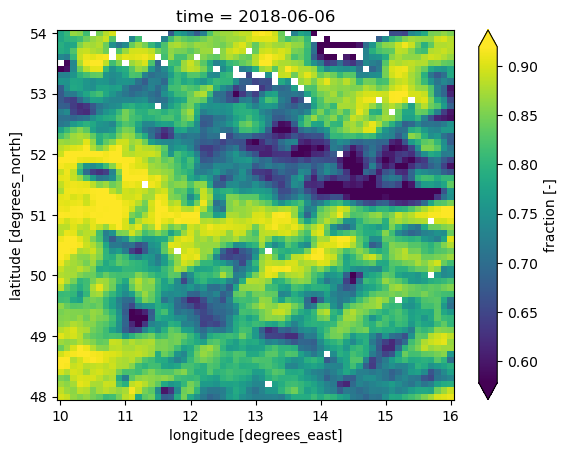

In [8]:
m = obs.fvc.isel(time=6000)
m.sel(lat=slice(54, 48), lon=slice(10, 16)).plot(robust=True)

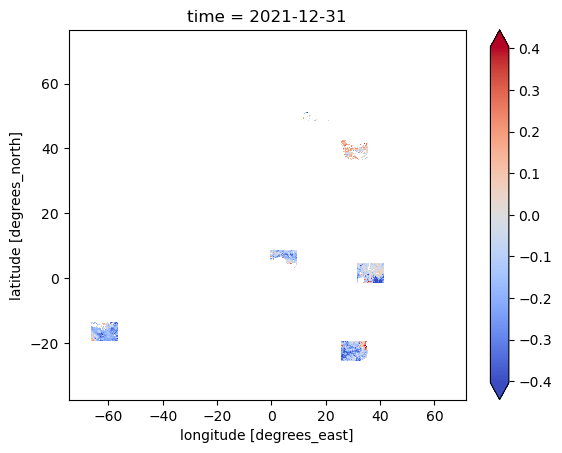

In [11]:
m = (pred.fvc_hat.isel(time=-1) - obs.fvc.isel(time=-1))
m.plot(robust=True, cmap='coolwarm')

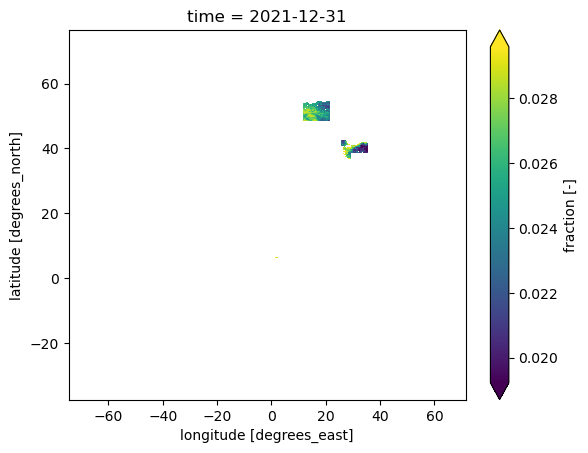

In [41]:
m = pred.fvc_vhat.isel(time=-1)
m.plot(robust=True)

In [22]:
import math

In [23]:
math.log(2 * math.pi)

1.8378770664093453

In [24]:
2 * math.pi

6.283185307179586

In [25]:
torch.log(2 * torch.pi)

NameError: name 'torch' is not defined

In [27]:
import torch

In [28]:
r = torch.arange(24 * 4)
r = r.view(24, -1)

In [29]:
r

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23],
        [24, 25, 26, 27],
        [28, 29, 30, 31],
        [32, 33, 34, 35],
        [36, 37, 38, 39],
        [40, 41, 42, 43],
        [44, 45, 46, 47],
        [48, 49, 50, 51],
        [52, 53, 54, 55],
        [56, 57, 58, 59],
        [60, 61, 62, 63],
        [64, 65, 66, 67],
        [68, 69, 70, 71],
        [72, 73, 74, 75],
        [76, 77, 78, 79],
        [80, 81, 82, 83],
        [84, 85, 86, 87],
        [88, 89, 90, 91],
        [92, 93, 94, 95]])

In [32]:
lst = obs.lst.sel(lat=50, lon=14).load()

In [38]:
import matplotlib.pyplot as plt

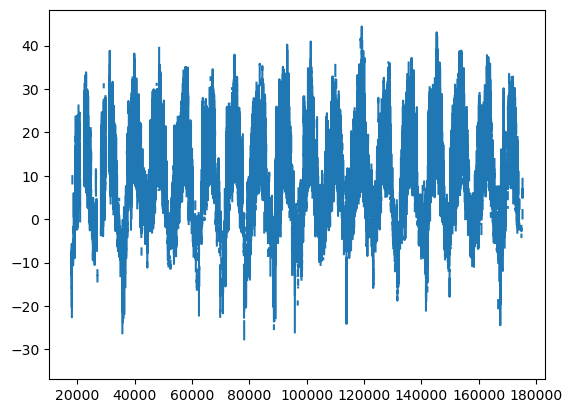

In [44]:
plt.plot(lst.values.transpose(1, 0).reshape(-1))

In [164]:
import torch
from torch import Tensor
from torch.utils.data import IterableDataset, DataLoader, default_collate
import pytorch_lightning as pl
import xarray as xr
import dask
import numpy as np
from collections import namedtuple
import torch.multiprocessing as mp
import queue
import time

import warnings
from typing import Any, Iterable

# Ignore anticipated PL warnings.
warnings.filterwarnings('ignore', '.*does not have many workers.*')
warnings.filterwarnings('ignore', '.*Your `IterableDataset` has `__len__` defined.*')

# We *must* use synchronous scheduler to avoid deadlock.
dask.config.set(scheduler='synchronous')


#BatchPattern = namedtuple('BatchPattern', 'f_hourly f_static t_hourly, t_daily coords')
#Coords = namedtuple('Coords', 'lat, lon, chunk')

from dataclasses import dataclass
from itertools import product
import pandas as pd


@dataclass
class DateLookup(object):
    start_context_year: int
    start_window_year: int
    end_window_year: int

    def __post_init__(self):
        num_leap_years = len([y for y in range(self.start_context_year, self.end_window_year + 1) if y % 4 == 0])
        self.start_context_date = f'{self.start_context_year}-01-{num_leap_years + 1:02d}'
        self.start_window_date = f'{self.start_window_year}-01-01'
        self.end_window_date = f'{self.end_window_year}-12-31'
        self.num_window_days = (pd.to_datetime(self.end_window_date) - pd.to_datetime(self.start_window_date)).days
        self.time_slice = slice(self.start_context_date, self.end_window_date)


@dataclass
class Coords(object):
    lat: int
    lon: int
    chunk: int
    window_start: str
    window_end: str
    num_days: int


@dataclass
class BatchPattern(object):
    f_hourly: Tensor
    f_static: Tensor
    t_hourly: Tensor
    t_daily: Tensor
    coords: Coords


class NotEnoughSamplesError(Exception):
    """Exception raised if not enough samples are left to fill a batch.
    """

    def __init__(self, message='Not enough samples left.'):
        super().__init__(message)


class GracefulExit(object):
    """Context manager for graceful shutdown of subprocesses and queues."""
    def __init__(self, processes: list[mp.Process], manager: mp.Manager):
        self.processes = processes
        self.manager = manager

    def __enter__(self):
        return self

    def __exit__(self, *args):
        for process in self.processes:
            process.terminate()
            process.join()
        self.manager.shutdown()


def collate_handle_none(x: Any) -> Any:

    if x[0] is None:
        return None
    else:
        return default_collate(x)


def batchpattern_collate(batch: list[BatchPattern]) -> BatchPattern:
    """Custom collate function to handle None values in BatchPattern.

    Note that this function is not intended to handle sparse None values, but the case
    where None is returned for one or more elements in BatchPattern, i.e., completely empty\
    features or targets.

    Args:
        batch: a list of BatchPattern.

    Returns:
        A BatchPattern corresponding to stacked individual elements of BatchPatterns.

    """
    elem_type = type(batch[0])

    return elem_type(*(collate_handle_none(x=samples) for samples in zip(*batch)))


class DataChunk(object):
    """Defines a single chunk and how to retreive data from it."""
    def __init__(
            self,
            data: xr.Dataset,
            mask: xr.DataArray,
            features_hourly: list[str] = [],
            features_static: list[str] = [],
            targets_hourly: list[str] = [],
            targets_daily: list[str] = [],
            context_size: int = 2,
            window_size: int = -1,
            chunk_index: int = -1,
            feature_scaling: dict[str, dict[str, float]] = None,
            dtype: str = 'float32',
            disable_shuffling: bool = False,
            dummy_data: bool = False) -> None:

        if dummy_data:
            data = xr.zeros_like(data)
        else:
            data = data

        mask = mask.stack(sample=('lat', 'lon')).reset_coords(drop=True)
        data = data.stack(sample=('lat', 'lon')).reset_coords(drop=True)
        self.data = data.where(mask, drop=True).load()

        self.features_hourly = features_hourly
        self.features_static = features_static
        self.targets_hourly = targets_hourly
        self.targets_daily = targets_daily
        self.context_size = context_size
        self.window_size = window_size
        self.chunk_index = chunk_index

        self.feature_scaling = feature_scaling
        self.dtype = dtype
        self.disable_shuffling = disable_shuffling
        self.dummy_data = dummy_data

        self.coords = self._get_coords()

        self._current_sample = 0

    def next(self) -> BatchPattern:
        sample, time = self.coords[self._current_sample]
        self._current_sample += 1

        data_sel = self.data.isel(sample=sample).sel(time=time.time_slice)

        return BatchPattern(
            f_hourly=self.xr2numpy(
                data_sel[self.features_hourly], scale=False), # CHANGE BACK TO TRUE
            f_static=self.xr2numpy(
                data_sel[self.features_static], scale=False), # CHANGE BACK TO TRUE
            t_hourly=self.xr2numpy(data_sel[self.targets_hourly], scale=False
            ),
            t_daily=self.xr2numpy(data_sel[self.targets_daily], scale=False
            ),
            coords=Coords(
                lat=data_sel.lat.item(),
                lon=data_sel.lon.item(),
                window_start=time.start_window_date,
                window_end=time.end_window_date,
                num_days=time.num_window_days,
                chunk=self.chunk_index)
        )

    def get_n_next(self, n: int):
        result = []
        for _ in range(n):
            result.append(self.next())

        return result

    def xr2numpy(self, x: xr.Dataset, scale: bool) -> np.ndarray | None:

        if len(x) == 0:
            return None

        if scale:
            if self.feature_scaling is None:
                raise ValueError(
                    'no `feature_scaling` has been passed but scling was requested.'
                )
            for var in x.data_vars:
                if var not in self.feature_scaling:
                    raise KeyError(
                        f'scling for variable `{var}` requested, but not present in `feature_scaling`.'
                    )
                scaling = self.feature_scaling[var]
                data_min = scaling['min']
                data_max = scaling['max']
                x[var] = (x[var] - data_min) * 2 / (data_max - data_min) - 1

        return x.to_array('var').transpose('time', 'hour', 'var', missing_dims='ignore').values.astype(self.dtype)

    def _get_coords(self) -> Iterable[tuple[int, DateLookup]]:
        sample_coords = np.arange(len(self.data.sample))
        time_coords = self._get_dates()

        coords = combination = [p for p in product(sample_coords, time_coords)]
        if not self.disable_shuffling:
            np.random.shuffle(coords)
        return coords

    def _get_dates(self) -> list[DateLookup]:
        context_size = self.context_size
        window_size = self.window_size

        years = np.unique(self.data.time.dt.year)
        num_years = len(years)

        if context_size >= num_years or context_size < 0:
            raise ValueError(
                f'{context_size=} should be in range [0, {num_years-1=}]'
            )

        if window_size < -1 or window_size == 0 or window_size > num_years:
            raise ValueError(
                f'{window_size=} should be in range [1, {num_years=}], or -1.'
            )

        if window_size == -1:
            window_size = num_years - context_size

        num_year_samples = (num_years - context_size) / window_size

        if num_year_samples % 1 != 0:
            raise ValueError(
                f'with {num_years=} of data and {context_size=}, the remaining years ({num_years-context_size=}) '
                f'must be equally dividable by the {window_size=}, which is not the case.'
            )

        date_lookup = [
            DateLookup(
                start_context_year=years[0]-context_size, start_window_year=years[0], end_window_year=years[-1]
            ) for years in np.asarray(years[context_size:]).reshape(-1, window_size)]

        return date_lookup

    @property
    def num_left(self) -> int:
        return len(self.coords) - self._current_sample

In [165]:
chunk = DataChunk(data, mask, features_hourly=['tair'], features_static=['wtd'], targets_daily=['fvc'], window_size=2)

In [166]:
b = chunk.get_n_next(5)[0]
b

BatchPattern(f_hourly=array([[[-0.7355245 ],
        [-1.1811272 ],
        [ 0.85463035],
        ...,
        [ 0.9156087 ],
        [-2.0728116 ],
        [-0.5309174 ]],

       [[ 0.35808435],
        [ 0.38134918],
        [-1.1706921 ],
        ...,
        [ 1.6525724 ],
        [-0.27758127],
        [-1.1922787 ]],

       [[-0.84781885],
        [-0.8677618 ],
        [ 1.2813034 ],
        ...,
        [-0.8902336 ],
        [ 2.0617712 ],
        [-0.57614124]],

       ...,

       [[ 1.7769337 ],
        [ 0.66324264],
        [ 0.7670303 ],
        ...,
        [ 1.8487707 ],
        [-0.6270666 ],
        [-2.594675  ]],

       [[ 1.8801407 ],
        [-0.09764334],
        [-1.7648761 ],
        ...,
        [ 0.10513287],
        [ 1.1812109 ],
        [-0.6117952 ]],

       [[ 0.10681788],
        [-0.3360802 ],
        [ 1.0496786 ],
        ...,
        [ 1.3221557 ],
        [ 1.4022503 ],
        [ 1.1777    ]]], dtype=float32), f_static=array([0.29569143], dt

In [162]:
b.f_hourly.shape

(1460, 24, 1)

In [157]:
chunk._get_coords()

[(195,
  YearLookup(start_context_year=2006, start_window_year=2008, end_window_year=2009)),
 (80,
  YearLookup(start_context_year=2002, start_window_year=2004, end_window_year=2005)),
 (31,
  YearLookup(start_context_year=2004, start_window_year=2006, end_window_year=2007)),
 (161,
  YearLookup(start_context_year=2006, start_window_year=2008, end_window_year=2009)),
 (136,
  YearLookup(start_context_year=2016, start_window_year=2018, end_window_year=2019)),
 (175,
  YearLookup(start_context_year=2002, start_window_year=2004, end_window_year=2005)),
 (27,
  YearLookup(start_context_year=2002, start_window_year=2004, end_window_year=2005)),
 (82,
  YearLookup(start_context_year=2016, start_window_year=2018, end_window_year=2019)),
 (50,
  YearLookup(start_context_year=2008, start_window_year=2010, end_window_year=2011)),
 (153,
  YearLookup(start_context_year=2012, start_window_year=2014, end_window_year=2015)),
 (68,
  YearLookup(start_context_year=2016, start_window_year=2018, end_win

In [141]:
import itertools

In [144]:
combination = [p for p in itertools.product([0, 1], ['a', 'b'])]
combination

[(0, 'a'), (0, 'b'), (1, 'a'), (1, 'b')]

In [13]:
2021 - 2002 + 1

20

In [131]:
from dataclasses import dataclass

@dataclass
class YearLookup(object):
    start_context_year: int
    start_window_year: int
    end_window_year: int

    def __post_init__(self):
        num_leap_years = len([y for y in range(self.start_context_year, self.end_window_year + 1) if y % 4 == 0])
        self.start_context_date = f'{self.start_context_year}-01-{num_leap_years + 1:02d}'
        self.start_window_date = f'{self.start_window_year}-01-01'
        self.end_window_date = f'{self.end_window_year}-12-31'
        self.num_window_days = (pd.to_datetime(self.end_window_date) - pd.to_datetime(self.start_window_date)).days


In [132]:
# 2002 to 2021
# 2004 to 2021

context_size = 2
window_size = 6
years = np.unique(data.time.dt.year)
num_years = len(years)

if context_size >= num_years or context_size < 0:
    raise ValueError(
        f'{context_size=} should be in range [0, {num_years-1=}]'
    )

if window_size < -1 or window_size == 0 or window_size > num_years:
    raise ValueError(
        f'{window_size=} should be in range [1, {num_years=}], or -1.'
    )

if window_size == -1:
    window_size = num_years - context_size

num_year_samples = (num_years - context_size) / window_size

if num_year_samples % 1 != 0:
    raise ValueError(
        f'with {num_years=} of data and {context_size=}, the remaining years ({num_years-context_size=}) '
        f'must be equally dividable by the {window_size=}, which is not the case.'
    )

years_lookup = [YearLookup(start_context_year=years[0]-context_size, start_window_year=years[0], end_window_year=years[-1]) for years in np.asarray(years[context_size:]).reshape(-1, window_size)]


In [133]:
years_lookup

[YearLookup(start_context_year=2002, start_window_year=2004, end_window_year=2009),
 YearLookup(start_context_year=2008, start_window_year=2010, end_window_year=2015),
 YearLookup(start_context_year=2014, start_window_year=2016, end_window_year=2021)]

In [134]:
y = years_lookup[0]

In [137]:
y.num_window_days / 365

6.002739726027397

In [106]:
data.sel(time=slice('2000', '2000'))

<xarray.Dataset>
Dimensions:  (time: 366, lat: 20, lon: 20, hour: 24)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
  * hour     (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
Dimensions without coordinates: lat, lon
Data variables:
    fvc      (time, lat, lon) float64 0.2256 nan nan 1.336 ... nan nan nan nan
    tair     (time, hour, lat, lon) float64 0.4601 -0.9646 ... -0.5674 1.816
    wtd      (lat, lon) float64 -0.6502 -0.5121 -0.6399 ... 0.3484 0.1055

In [1]:
import xarray as xr

In [2]:
d = xr.open_zarr('/Net/Groups/BGI/scratch/bkraft/drought_data/cube.zarr/')
d

<xarray.Dataset>
Dimensions:             (lat: 1140, lon: 1460, dayofyear: 366, fold: 6,
                         time: 7305, hour: 24)
Coordinates:
  * dayofyear           (dayofyear) int64 0 1 2 3 4 5 ... 361 362 363 364 365
  * fold                (fold) int64 0 1 2 3 4 5
  * hour                (hour) int64 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22 23
  * lat                 (lat) float32 76.5 76.4 76.3 76.2 ... -37.2 -37.3 -37.4
  * lon                 (lon) float32 -74.5 -74.4 -74.3 -74.2 ... 71.2 71.3 71.4
  * time                (time) datetime64[ns] 2002-01-01 ... 2021-12-31
Data variables: (12/18)
    canopyheight        (lat, lon) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>
    fold_mask           (fold, lat, lon) bool dask.array<chunksize=(1, 20, 20), meta=np.ndarray>
    fvc                 (time, lat, lon) float32 dask.array<chunksize=(300, 20, 20), meta=np.ndarray>
    fvc_ano             (time, lat, lon) float32 dask.array<chunksize=(300, 20, 20), meta=np.ndarray>
    fvc_msc             (dayofyear, lat, lon) float32 dask.array<chunksize=(366, 20, 20), meta=np.ndarray>
    lst                 (time, hour, lat, lon) float32 dask.array<chunksize=(300, 24, 20, 20), meta=np.ndarray>
    ...                  ...
    sandfrac            (lat, lon) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>
    ssrd                (time, hour, lat, lon) float32 dask.array<chunksize=(300, 24, 20, 20), meta=np.ndarray>
    t2m                 (time, hour, lat, lon) float32 dask.array<chunksize=(300, 24, 20, 20), meta=np.ndarray>
    topidx              (lat, lon) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>
    tp                  (time, hour, lat, lon) float32 dask.array<chunksize=(300, 24, 20, 20), meta=np.ndarray>
    wtd                 (lat, lon) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>

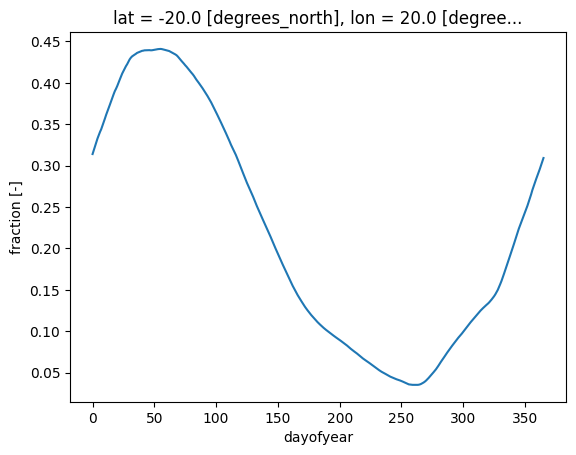

In [10]:
d.fvc_msc.sel(lat=-20, lon=20).plot()

In [127]:
fvc = d.fvc.sel(lat=40, lon=20).load()

In [128]:
fvc

<xarray.DataArray 'fvc' (time: 7305)>
array([       nan,        nan,        nan, ..., 0.32399398, 0.2925945 ,
       0.2654025 ], dtype=float32)
Coordinates:
    lat      float32 40.0
    lon      float32 20.0
  * time     (time) datetime64[ns] 2002-01-01 2002-01-02 ... 2021-12-31
Attributes:
    data_max:   0.9899999499320984
    data_min:   0.0
    long_name:  fraction
    units:      -

In [129]:
import pandas as pd
import numpy as np

def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit, fit

def detrendynew_dim(da, dim, deg=1):
    da_year = da.groupby('time.year').mean().compute()
    p = da_year.polyfit(dim=dim, deg=deg)
    new_time = (da.time.dt.year + ((da.time.dt.dayofyear.groupby('time.year') / da.time.dt.dayofyear.groupby('time.year').max())) - 0.5)
    fit = xr.polyval(new_time, p.polyfit_coefficients)
    detrend = da - fit
    return detrend, fit

def detrendy_dim(da, dim, deg=1):
    da = da.groupby('time.year').mean().compute()
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    detrend = da - fit
    fit = fit.assign_coords(year=pd.to_datetime([f'{y}-06-30' for y in fit.year.values]))
    return detrend, fit

In [140]:
fvc_dt, fit = detrendy_dim(fvc, 'year', 1)

In [141]:
fvc_dt_n, fit_n = detrendynew_dim(fvc, 'year', 1)

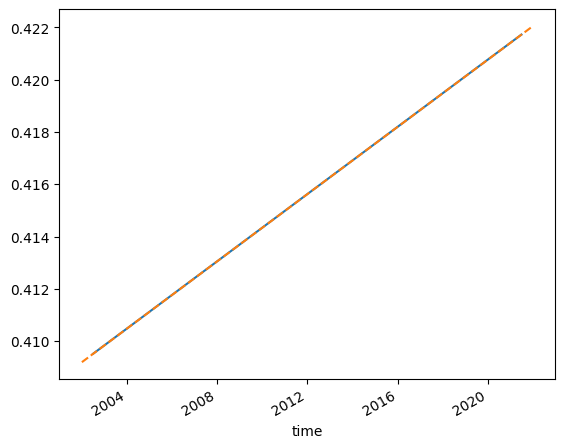

In [142]:
fit.plot()
fit_n.plot(ls='--')

In [143]:
fvc_dt

<xarray.DataArray (year: 20)>
array([            nan,             nan,  1.44417058e-02, -1.33964909e-02,
        9.89721654e-03, -4.21141803e-02, -2.50431679e-02, -1.30777122e-04,
        3.64597431e-02,  1.70913618e-03, -8.07958196e-03,  2.47354012e-02,
        3.71243197e-02,  8.43440249e-03,  4.76809465e-03, -2.20662108e-02,
       -1.52506842e-02, -7.68579238e-05, -6.35638240e-03, -5.05568619e-03])
Coordinates:
    lat      float32 40.0
    lon      float32 20.0
  * year     (year) int64 2002 2003 2004 2005 2006 ... 2017 2018 2019 2020 2021

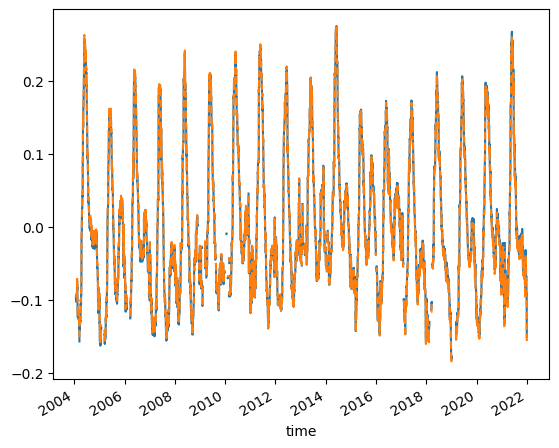

In [145]:
(fvc-fvc.mean()).plot()
fvc_dt_n.plot(ls='--')

In [66]:
fit.assign_coords(year=pd.to_datetime([f'{y}-06-30' for y in fit.year.values]))

<xarray.DataArray (year: 20)>
array([0.16408134, 0.16905359, 0.17402585, 0.17899811, 0.18397036,
       0.18894262, 0.19391488, 0.19888713, 0.20385939, 0.20883164,
       0.2138039 , 0.21877616, 0.22374841, 0.22872067, 0.23369293,
       0.23866518, 0.24363744, 0.2486097 , 0.25358195, 0.25855421])
Coordinates:
    lat      float32 -20.0
    lon      float32 20.0
  * year     (year) datetime64[ns] 2002-06-30 2003-06-30 ... 2021-06-30

In [42]:
fit['']

<xarray.DataArray (year: 20)>
array([0.16408134, 0.16905359, 0.17402585, 0.17899811, 0.18397036,
       0.18894262, 0.19391488, 0.19888713, 0.20385939, 0.20883164,
       0.2138039 , 0.21877616, 0.22374841, 0.22872067, 0.23369293,
       0.23866518, 0.24363744, 0.2486097 , 0.25358195, 0.25855421])
Coordinates:
    lat      float32 -20.0
    lon      float32 20.0
  * year     (year) int64 2002 2003 2004 2005 2006 ... 2017 2018 2019 2020 2021

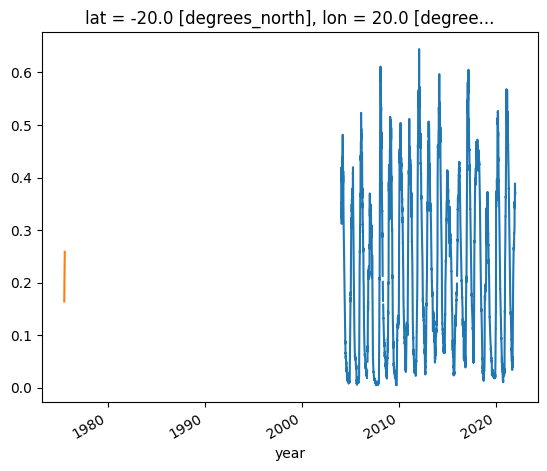

In [41]:
fvc.plot()
fit.plot()

In [30]:
fvc_dt, fit = detrend_dim(fvc, 'time', 1)

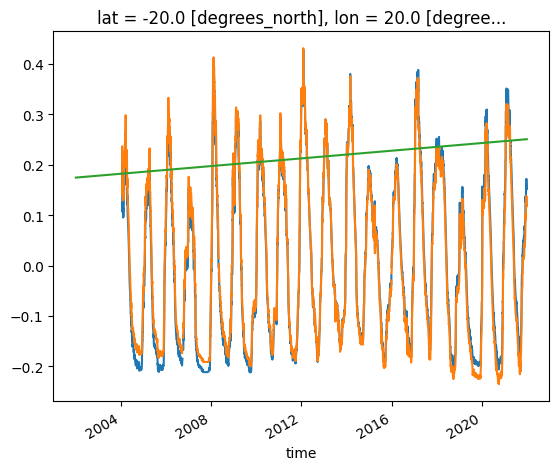

In [31]:
(fvc-fvc.mean()).plot()
fvc_dt.plot()
fit.plot()

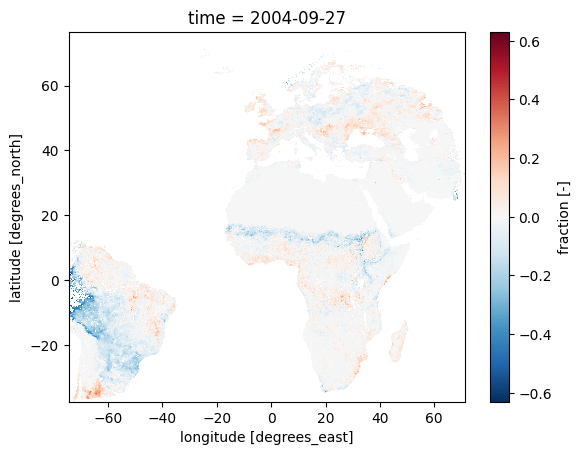

In [8]:
d.fvc_ano.isel(time=1000).plot()

In [32]:
import traceback

try:
    raise ValueError
except ValueError as e:
    tb = (e, traceback.format_exc())
else:
    tb = "No error"

if isinstance(tb, tuple):
    if isinstance(tb[0], Exception):
        print(tb[1])
        raise tb[0]

Traceback (most recent call last):
  File "/raid/scratch/tmp/ipykernel_73217/1794405353.py", line 4, in <module>
    raise ValueError
ValueError



ValueError: 

In [20]:
tb[1]

'Traceback (most recent call last):\n  File "/raid/scratch/tmp/ipykernel_73217/118319411.py", line 4, in <module>\n    raise ValueError\nValueError\n'

In [29]:
tb[0].__traceback__.

In [31]:
tb[0].with_traceback(tb[0].__traceback__)

ValueError()

In [6]:
import torch
import matplotlib.pyplot as plt
from utils.torch_utils import EncodeHourlyToDaily


In [3]:
encode = EncodeHourlyToDaily(num_inputs=4, num_hidden=32, num_encoding=10, dropout=0.0, outpout_channel_last=False)
x = torch.randn(2, 100, 24, 4)
y = encode(x)

In [4]:
x.shape

torch.Size([2, 100, 24, 4])

In [5]:
y.shape

torch.Size([2, 10, 100])

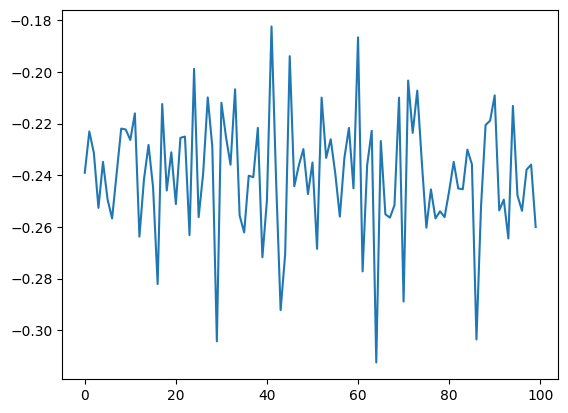

In [8]:
plt.plot(y[0, 0, :].detach().numpy())